# Surgery pipeline with TRVAE - comparison between zero-, one-shot and full query training

In [2]:
import scib

In [3]:
import os
import timeit
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

Global seed set to 0
/home/alextopalova/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/alextopalova/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/home/alextopalova/.local/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [6]:
condition_key = 'batch'
cell_type_key = 'tissue'
target_conditions = ["10X"]


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [7]:
url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
output = 'pbmc.h5ad'
# gdown.download(url, output, quiet=False)

In [8]:
adata = sc.read('pbmc.h5ad')

/home/alextopalova/.local/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/alextopalova/.local/lib/python3.8/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/alextopalova/.local/lib/python3.8/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/alextopalova/.local/lib/python3.8/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/alextopalova/.local/lib/python3.8/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/chemistry' was written without

In [9]:
adata.X = adata.layers["counts"].copy()

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [10]:
sc.pp.normalize_total(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata.raw = source_adata
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [ ]:
source_adata

AnnData object with n_obs × n_vars = 22779 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [ ]:
target_adata

View of AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [ ]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 



In [ ]:
trvae.train(
    n_epochs=25,
    alpha_epoch_anneal=5,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

 |████████████████████| 100.0%  - val_loss: 3673.2319607205 - val_recon_loss: 3610.0585666233 - val_kl_loss: 16.5893643697 - val_mmd_loss: 46.5840318468
Saving best state of network...
Best State was in Epoch 24


### Create anndata file of latent representation and compute UMAP

In [ ]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['tissue'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

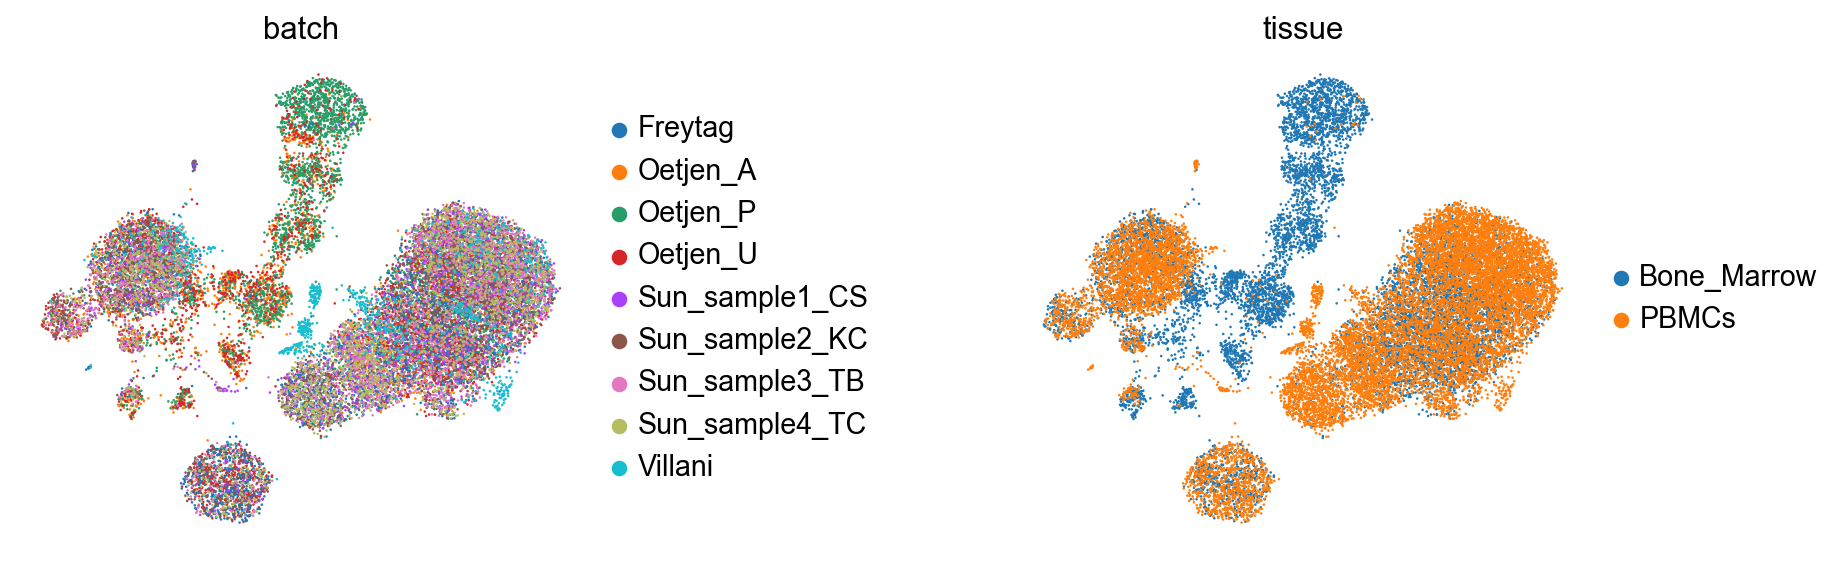

In [ ]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'tissue'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [ ]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

### Perform surgery on reference model and train on query dataset using zero-shot mapping

In [ ]:
start_time_0 = timeit.default_timer()

query_model_zero = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 0)

time_zero = timeit.default_timer() - start_time_0
print(f'Executed in {time_zero} seconds') 

AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 

Device cpu
Processing original category: 10X n_obs: 10727
  processing Oetjen_A
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing Sun_sample1_CS
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC
  processing Villani

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/ou

### Perform surgery on reference model and train on query dataset using one-shot mapping

In [ ]:
start_time_1 = timeit.default_timer()

query_model_one = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 1)

time_one = timeit.default_timer() - start_time_1
print(f'Executed in {time_one} seconds') 

AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 

Device cpu
Processing original category: 10X n_obs: 10727
  processing Oetjen_A
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing Sun_sample1_CS
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC
  processing Villani

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/ou

### Perform surgery on reference model and train on query dataset using full query training

In [ ]:
query_model_full = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)

AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 



In [ ]:
start_time_f = timeit.default_timer()

query_model_full.train(
    n_epochs=15,
    alpha_epoch_anneal=2,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

time_full = timeit.default_timer() - start_time_f
print(f'Executed in {time_full} seconds') 

 |████████████████████| 100.0%  - val_loss: 4724.9752061632 - val_recon_loss: 4705.9595811632 - val_kl_loss: 19.0155648126 - val_mmd_loss: 0.0000000000
Saving best state of network...
Best State was in Epoch 14
Executed in 139.80505410000478 seconds


#### Time Benchmarking results

In [ ]:
time_zero

62.45951630000491

In [ ]:
time_one

59.391481500002556

In [ ]:
time_full

139.80505410000478

#### Latent Representations

In [14]:
adata_latent_array = []
models = [query_model_zero, query_model_one, query_model_full]

In [ ]:
for model in models:
    adata_latent = sc.AnnData(model.get_latent())
    adata_latent.obs['tissue'] = target_adata.obs[cell_type_key].tolist()
    adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()
    adata_latent_array.append(adata_latent)

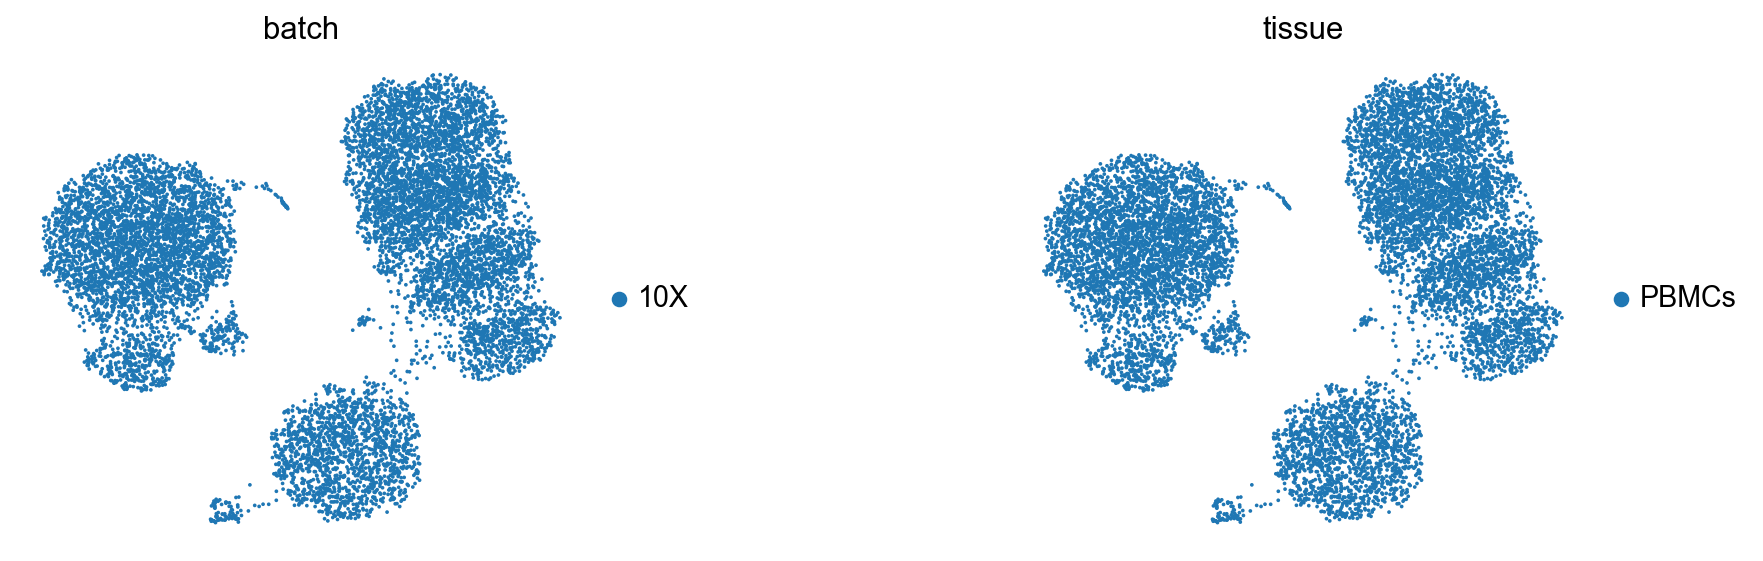

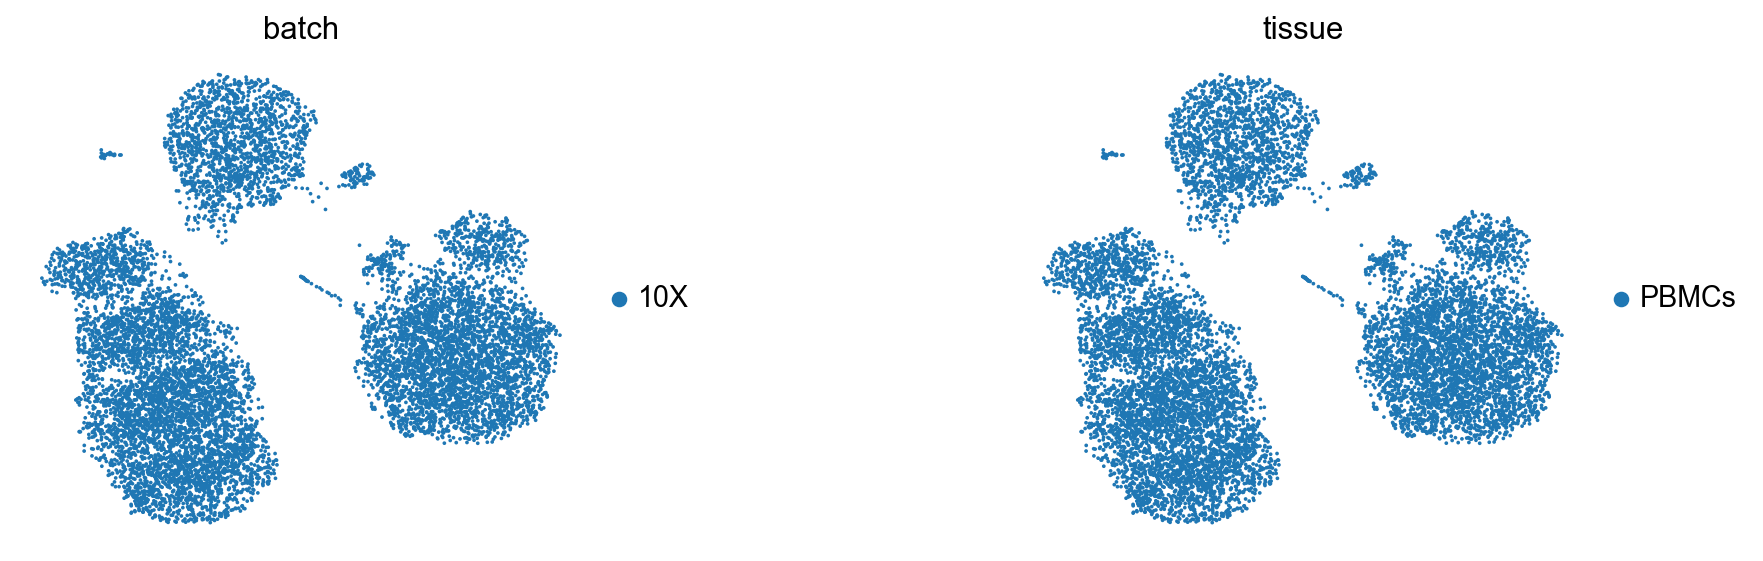

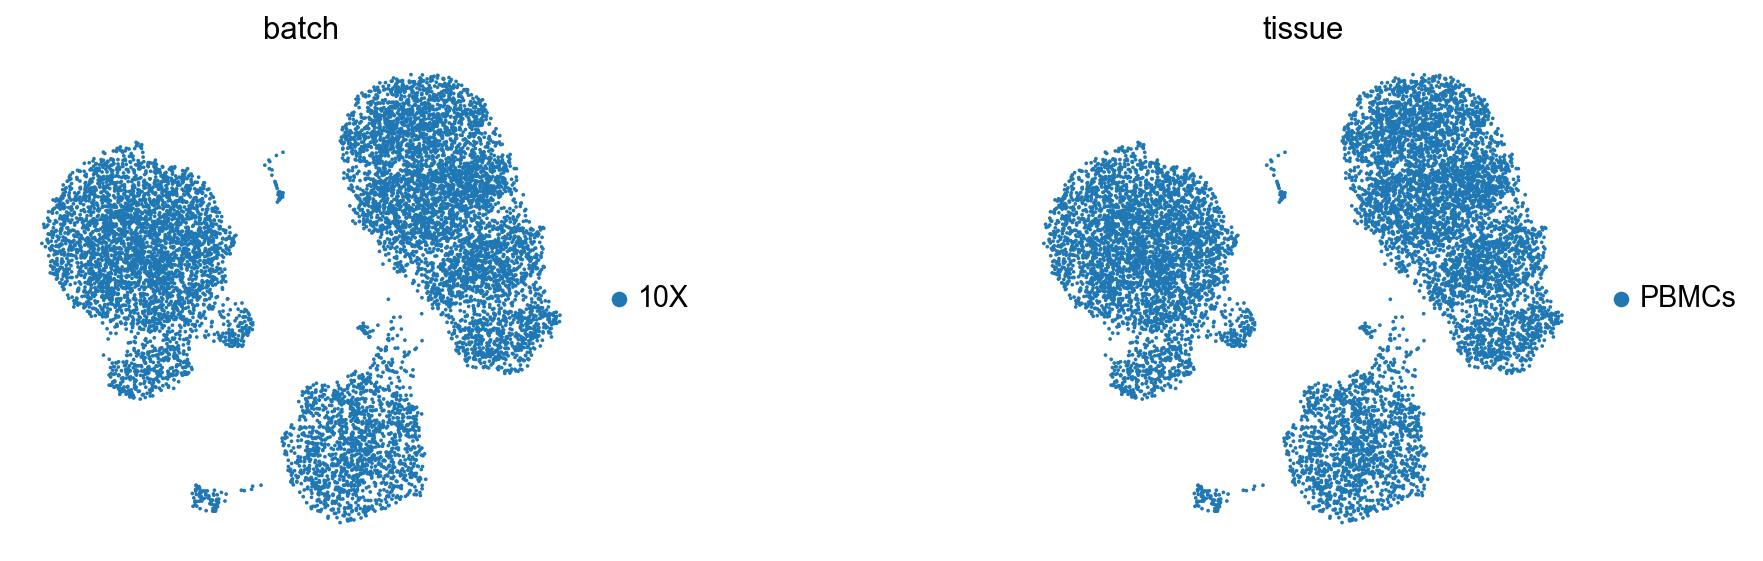

In [ ]:
for adata_query in adata_latent_array:
    sc.pp.neighbors(adata_query, n_neighbors=8)
    sc.tl.leiden(adata_query)
    sc.tl.umap(adata_query)
    sc.pl.umap(adata_query,
           color=['batch', 'tissue'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
surg_path = ['query_model_zero', 'query_model_one', 'query_model_full']
i = 0
for model in models:
    model.save(surg_path[i], overwrite=True)
    i+=1

### Get latent representation of reference + query dataset and compute UMAP

In [12]:
full_latent_array = []

In [15]:
for model in models:
    full_latent = sc.AnnData(model.get_latent(adata.X, adata.obs[condition_key]))
    full_latent.obs['tissue'] = adata.obs[cell_type_key].tolist()
    full_latent.obs['batch'] = adata.obs[condition_key].tolist()
    full_latent_array.append(full_latent)

/home/alextopalova/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


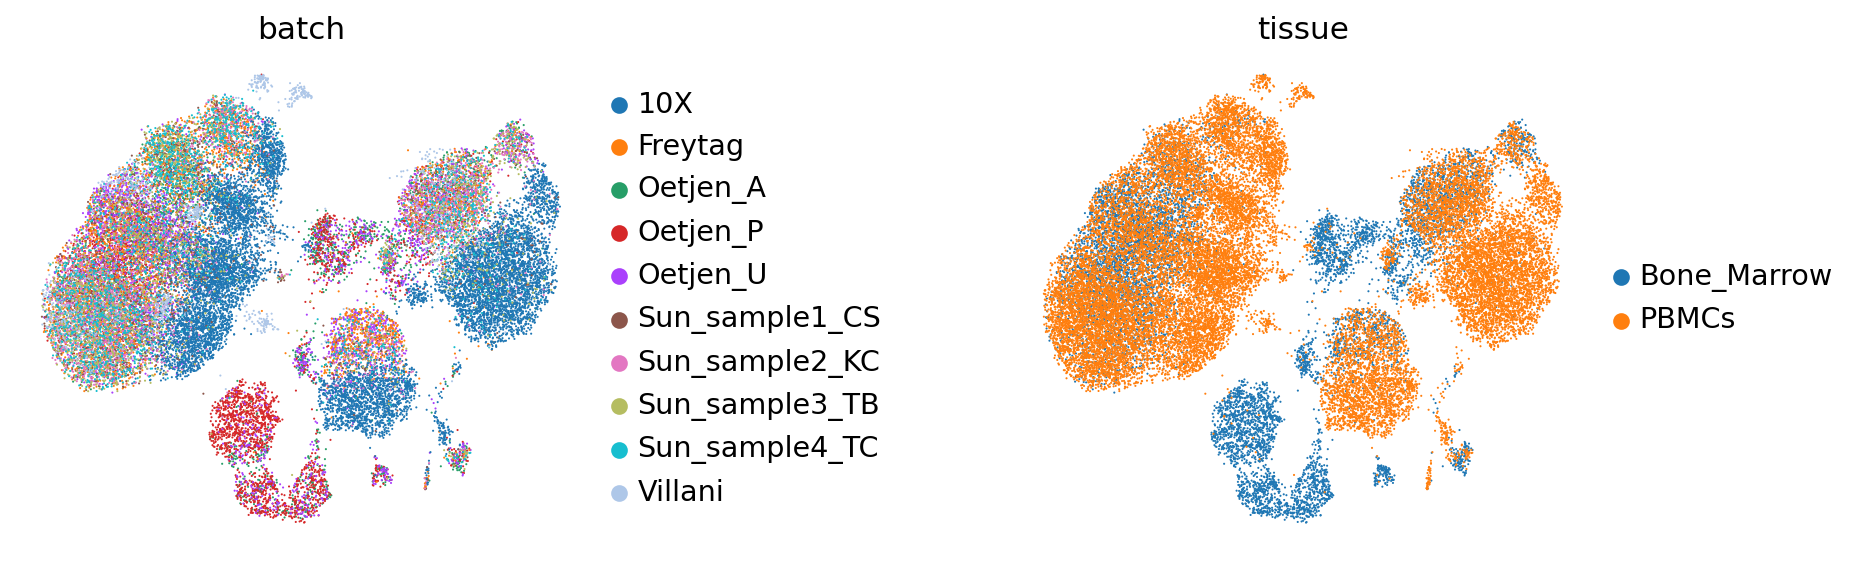

/home/alextopalova/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


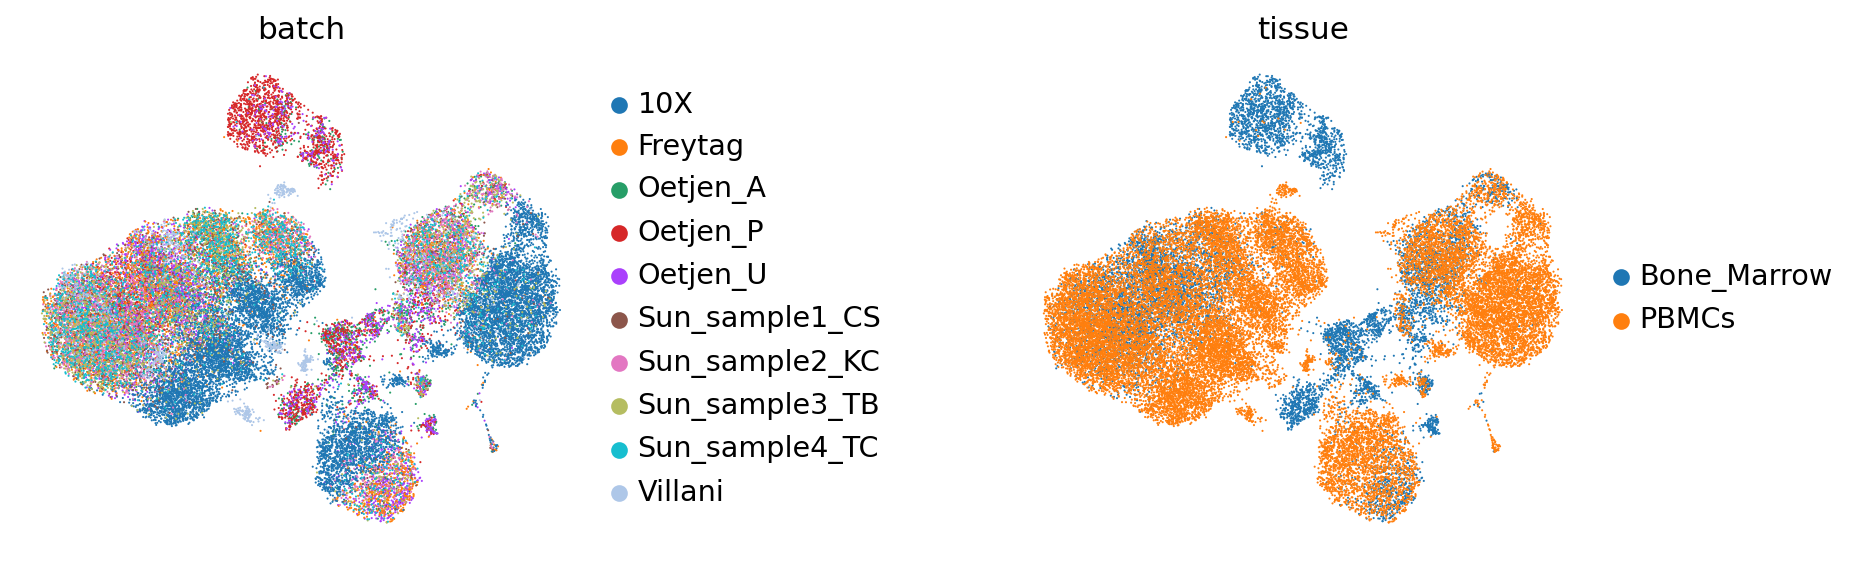

/home/alextopalova/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


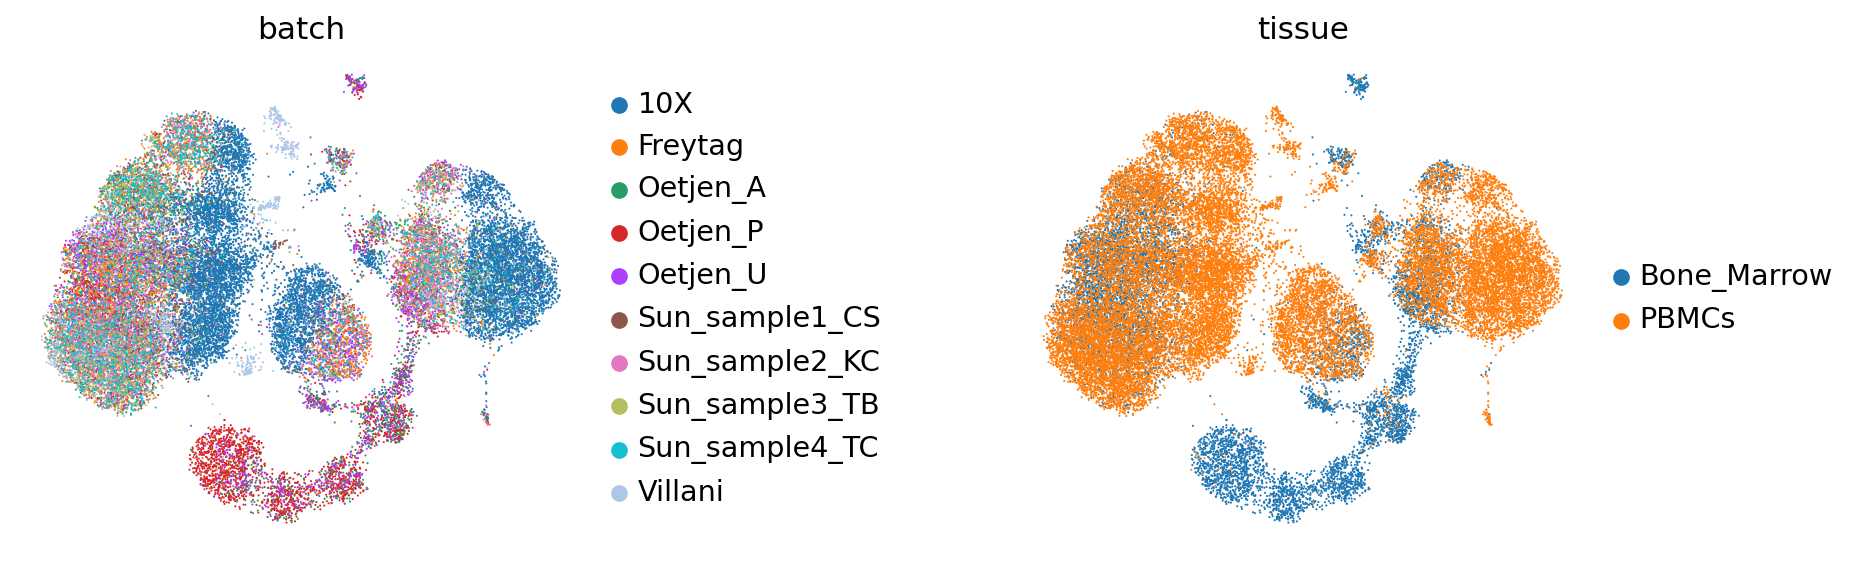

In [16]:
for full_latent in full_latent_array:
    sc.pp.neighbors(full_latent, n_neighbors=8)
    sc.tl.leiden(full_latent)
    sc.tl.umap(full_latent)
    sc.pl.umap(full_latent,
           color=['batch', 'tissue'],
           frameon=False,
           wspace=0.6,
           )

## Benchmarking for Biological Conservation and Batch Correction

In [17]:
results_array = []

In [19]:
for full_latent in full_latent_array:
    results = scib.metrics.metrics(
        adata, full_latent,
        batch_key= condition_key, label_key= cell_type_key, organism= 'human', subsample=1., embed = 'X_umap',
        graph_conn_=True, nmi_ = True, ari_ = True,
        ilisi_=True, isolated_labels_asw_= True, cell_cycle_= True,
        silhouette_=True
    )
    results_array.append(results)

NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
iLISI score...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
iLISI score...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
iLISI score...


In [27]:
results_array[0].dropna()

0
NMI_cluster/label          0.125064
ARI_cluster/label          0.040196
ASW_label                  0.504215
ASW_label/batch            0.827562
cell_cycle_conservation    0.359815
isolated_label_silhouette  0.504215
graph_conn                 0.986274
iLISI                      0.258070

In [28]:
results_array[1].dropna()

0
NMI_cluster/label          0.125605
ARI_cluster/label          0.038122
ASW_label                  0.505142
ASW_label/batch            0.846344
cell_cycle_conservation    0.277378
isolated_label_silhouette  0.505142
graph_conn                 0.983195
iLISI                      0.261756

In [29]:
results_array[2].dropna()

0
NMI_cluster/label          0.131314
ARI_cluster/label          0.043403
ASW_label                  0.522328
ASW_label/batch            0.836494
cell_cycle_conservation    0.362094
isolated_label_silhouette  0.522328
graph_conn                 0.983811
iLISI                      0.259092